In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os
plt.rcParams['figure.figsize']=[16,9]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }

urls1617 = {'EN': 'http://www.football-data.co.uk/mmz4281/1617/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1617/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1617/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1617/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1617/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1617/N1.csv'
                          }


In [3]:
all_data1617=get_data(urls1617)
all_data=get_data(urls)
#all_data['EN']=add_match(all_data['EN'],'Liverpool',2,'Newcastle',0)
#all_data['EN']=add_match(all_data['EN'],'Tottenham',2,'Huddersfield',0)
#all_data['EN']=add_match(all_data['EN'],'Brighton',2,'Arsenal',1)
#all_data['EN']=add_match(all_data['EN'],'Man City',1,'Chelsea',0)
#all_data['EN']=add_match(all_data['EN'],'Man United',2,'Liverpool',1)
all_data['EN'].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
314,2018-07-04,Bournemouth,Crystal Palace,2,2
315,2018-07-04,Brighton,Huddersfield,1,1
316,2018-07-04,Everton,Liverpool,0,0
317,2018-07-04,Leicester,Newcastle,1,2
318,2018-07-04,Man City,Man United,2,3
319,2018-07-04,Stoke,Tottenham,1,2
320,2018-07-04,Watford,Burnley,1,2
321,2018-07-04,West Brom,Swansea,1,1
322,2018-08-04,Arsenal,Southampton,3,2
323,2018-08-04,Chelsea,West Ham,1,1


In [4]:
calibrator_1617=Calibrator('calibration_1617.pkl')
for _country in all_data1617:
    calibrator_1617.process_data(all_data1617[_country],_country)

calibration_1617.pkl  exists.
file exists, loading
2132


In [6]:
calibrator=Calibrator('calibration.pkl',old_teams=calibrator_1617.teams)
for _country in all_data:
    calibrator.process_data(all_data[_country],_country)
teams=calibrator.teams

calibration.pkl  exists.
file exists, loading
1793


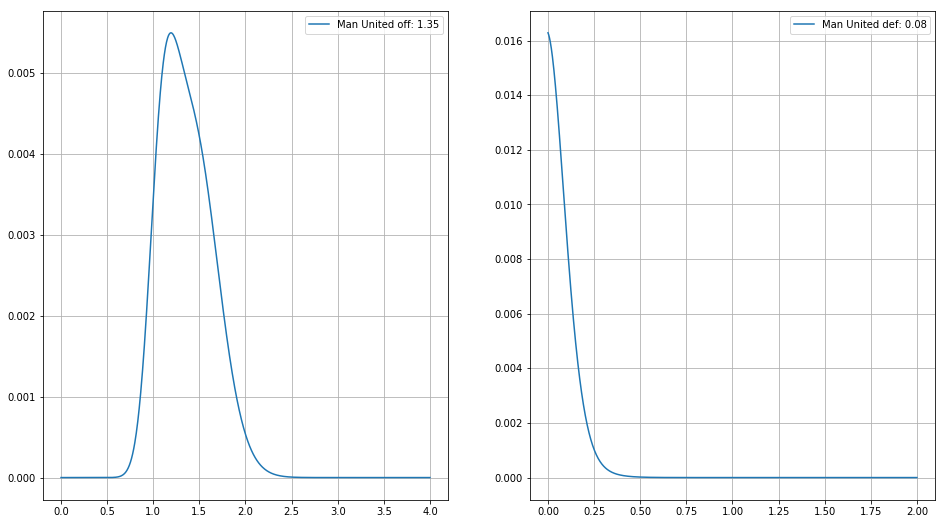

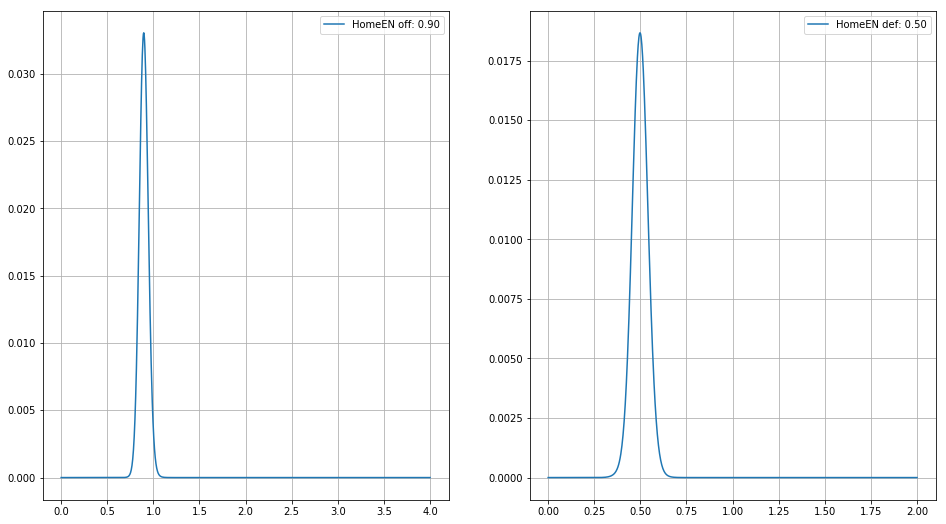

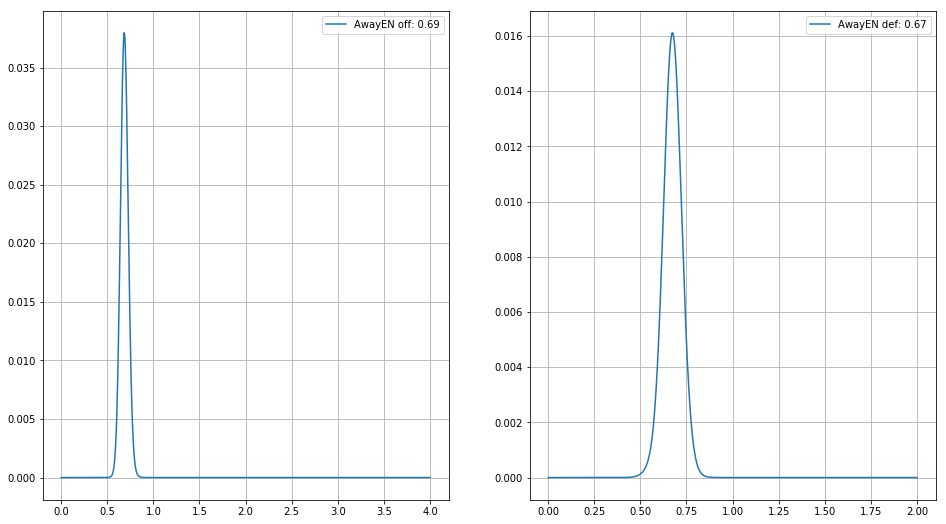

In [7]:
country='EN'
plt.rcParams['figure.figsize']=[16,9]
calibrator.teams['Man United'].plt()
calibrator.teams['Home'+country].plt()
calibrator.teams['Away'+country].plt();

In [8]:
Teams=dict()
League=dict()

In [23]:
country='EN'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=1000000)
League[country].season_report()

[ 0.21088027 -0.17476313]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,98.6,94,102,1,1,100.0,100.00,2.23,0.15,0.00
Man United,83.9,79,89,3,2,0.0,99.99,1.35,0.08,0.00
Tottenham,80.0,75,85,4,2,0.0,99.80,1.56,0.08,0.00
Liverpool,78.0,74,82,4,3,0.0,99.13,1.63,0.22,0.00
Chelsea,68.7,64,73,6,5,0.0,1.06,1.33,0.13,0.00
Arsenal,64.7,60,70,7,5,0.0,0.01,1.39,0.40,0.00
Burnley,57.6,53,62,8,6,0.0,0.00,0.48,0.18,0.00
Leicester,51.1,46,56,9,7,0.0,0.00,0.90,0.57,0.00
Everton,48.8,44,54,11,8,0.0,0.00,0.74,0.55,0.00
Newcastle,44.6,40,50,13,9,0.0,0.00,0.57,0.43,0.00


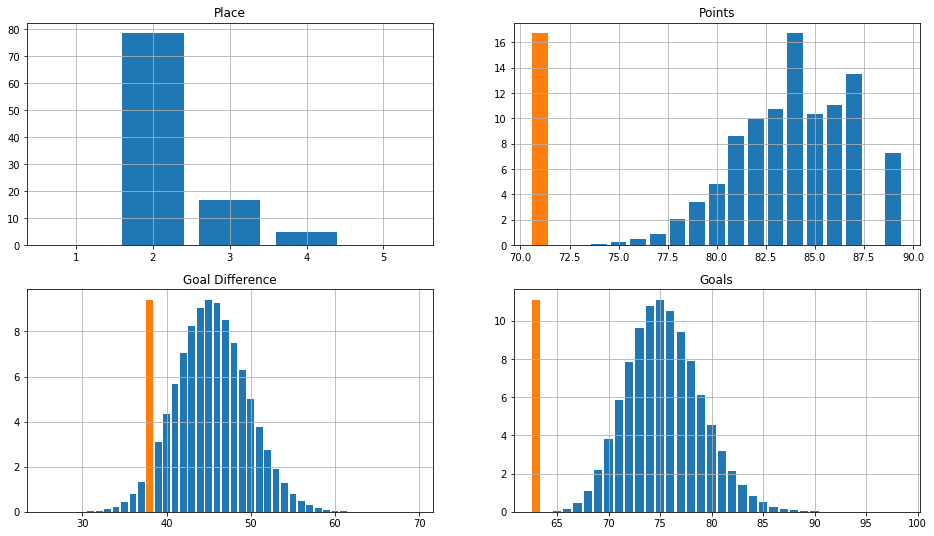

In [10]:
PremierLeague=League['EN']
PremierLeague.team_report('Man United')

# Most important matches

array([99.9926    , 99.99839085, 99.93333793, 99.97846814])

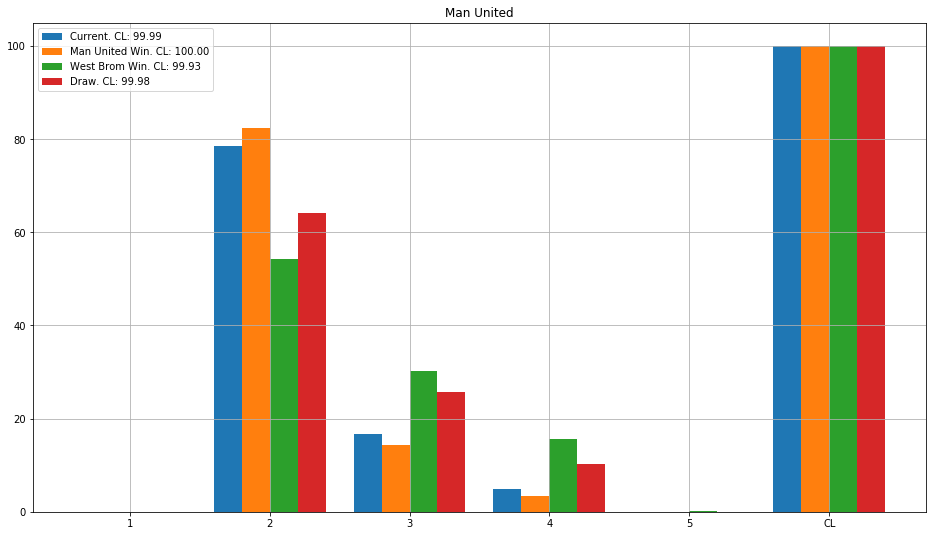

In [11]:
imp=[]
ref_team='Man United'
#ref_team='Liverpool'
#ref_team='Arsenal'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False,place=2,or_better=True)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
    #imp.append(1/pcl.min())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

array([99.9926    , 99.9998097 , 99.97548209, 99.99540346])

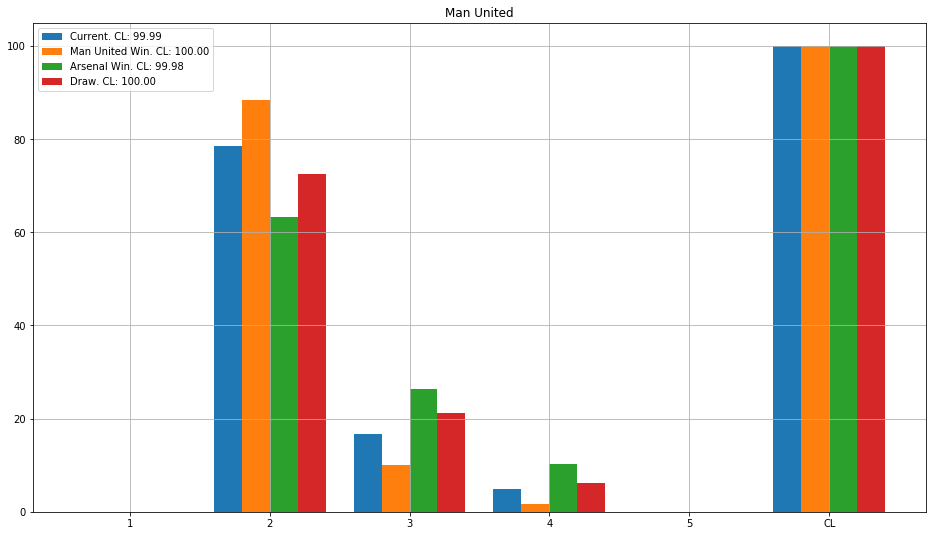

In [13]:
PremierLeague.what_if('Man United v Arsenal',ref_team='Man United')

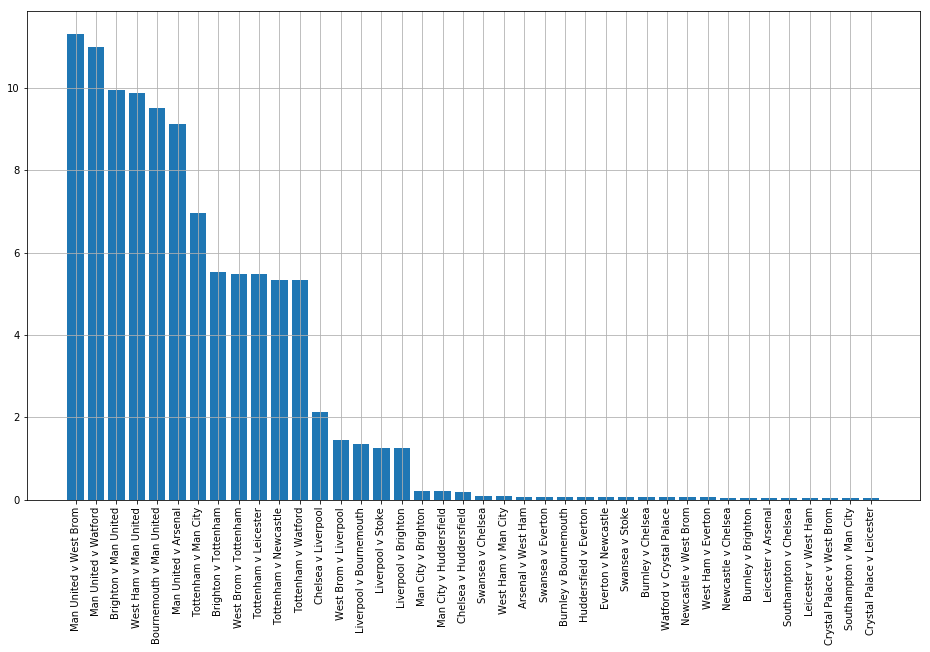

In [14]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(40)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)

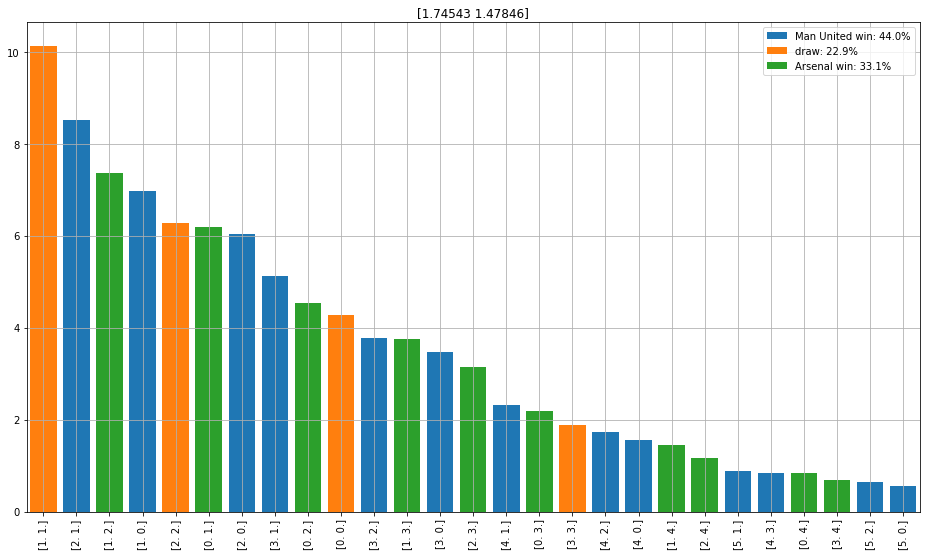

In [15]:
teams['Man United']+teams['Arsenal']

2.2005445999999997

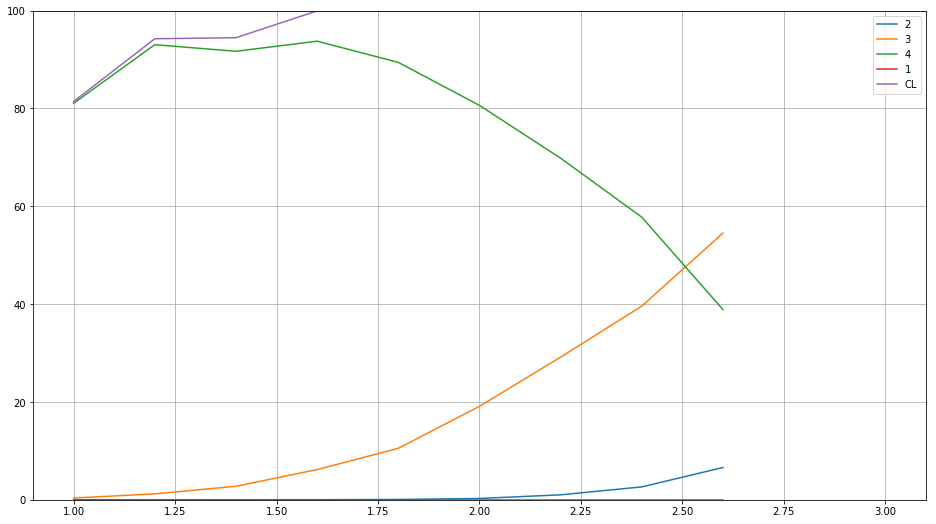

In [20]:
team_name='Man United'
#team_name='Tottenham'
#team_name='Chelsea'
team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],6])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
        p[jj,4]=(plc[ind]==1).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,4],label='1')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
pnts.mean()/n